# Import & Install 

In [14]:
# GPU 확인 
!nvidia-smi

Wed Aug 30 09:14:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |  14266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import seaborn as sns
import re

from transformers import BertTokenizer, BertForSequenceClassification
import torch

import os
import math
import random
from typing import Optional, Sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, f1_score

import torch.nn as nn
from transformers import AutoModel, AutoConfig

from tqdm import tqdm
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, AutoModel, AutoConfig

import gc
import json
import tensorflow
import matplotlib

import requests
import tarfile

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm.notebook import tqdm    # Process 과정을 보기 위해

from tqdm import tqdm    
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

from konlpy.tag import Mecab
import sentencepiece as spm

from transformers import ElectraTokenizer, ElectraForSequenceClassification

from collections import Counter
from konlpy.tag import Mecab

## 0) Data Load

In [16]:
train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
train = pd.read_csv(train_data_path)

test_data_path ="/aiffel/aiffel/dktc/data/test.json"
with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)
test = pd.DataFrame({'file_name':list(test.keys()),'conversation':[list(test.values())[i]['text'] for i in range(len(list(test.values())))] })

train.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# 1

In [17]:
def split_users(x):
    x = x.split('\n')
    userA = x[::2]
    userB = x[1::2]
    return pd.Series(['\n'.join(userA), '\n'.join(userB)], index=['A', 'B'])

train[['A', 'B']] = train['conversation'].apply(split_users)

In [18]:
train[train['class'].str.contains('협박')][200:210]

,idx,class,conversation,A,B
955,955,협박 대화,넌 그냥 죽어야해 이 한국남자야\n그러지 마세요 왜 그러세요\n넌 그냥 죽어 \n죽...,넌 그냥 죽어야해 이 한국남자야\n넌 그냥 죽어 \n한국남자는 여자들 강간하고 노예...,그러지 마세요 왜 그러세요\n죽기전에 이유나 들어보자 왜 그러는데요\n전 적어도 그...
959,959,협박 대화,조국을 배신하는 건가?\n말 똑바로 해. 조국이라고 할 것도 없으니까. \n고아인 ...,조국을 배신하는 건가?\n고아인 너에게 기회를 주고 키워준 건 조국이야. \n조국의...,말 똑바로 해. 조국이라고 할 것도 없으니까. \n누가 키워달라고 했나? 어린시절은...
961,961,협박 대화,비행기에 위급 환자가 생겼습니다. 과다출혈로 피가 부족한 상태이오니 헌혈 부탁드립니...,비행기에 위급 환자가 생겼습니다. 과다출혈로 피가 부족한 상태이오니 헌혈 부탁드립니...,형 입니다. 형 이에요.\n의료진 있으니 제발 안심하고 와주세요. 제 동생 죽어요 ...
963,963,협박 대화,저번에 말한 물건들 준비됐어?\n아니 선생님. 시간을 조금만 더 주세요.\n저번에도...,저번에 말한 물건들 준비됐어?\n저번에도 그랬잖아. 이번엔 그냥 안넘어가\n그래? ...,아니 선생님. 시간을 조금만 더 주세요.\n그리고 원래 300개만 준비해달라 하셨는...
964,964,협박 대화,너 돈 언제 갚을꺼야?\n미안해. 다음달까지 기달려줘\n벌써 6개월이나 더 기달려줬...,너 돈 언제 갚을꺼야?\n벌써 6개월이나 더 기달려줬잖아. 언제까지 기달려달라고 하...,미안해. 다음달까지 기달려줘\n제발 믿고 기달려줄 수 없을까?? 정말 미안해. 다음...
965,965,협박 대화,니가.감히. 우리 아빠를 죽음으로 몰고 가놓고.?\n민재야.제발.미안해.나. 나 좀...,니가.감히. 우리 아빠를 죽음으로 몰고 가놓고.?\n니가 그 때 술만 안먹었으면 아...,민재야.제발.미안해.나. 나 좀 살려줘.\n미안해. 내가 그 때 너무.생각이 짧았어...
968,968,협박 대화,아니 나한테 송아지를 넘기기로 했으면서 이제와서 무슨말인가\n아 저기 옆마을 한씨가...,아니 나한테 송아지를 넘기기로 했으면서 이제와서 무슨말인가\n아니 그래도 사람이 약...,아 저기 옆마을 한씨가 더 비싸게 쳐주기로한다지 뭔가\n약속은먼저 했는데 나도 돈이...
969,969,협박 대화,너 오랜만이다.\n. 그래. 근데 오랜만이다. 그런데 우리가 이럴 사이는 아니지 않...,너 오랜만이다.\n하.! 너 많이도 컸다 어릴 때는 많이 맞았던 주제에 \n이 새끼...,. 그래. 근데 오랜만이다. 그런데 우리가 이럴 사이는 아니지 않냐?\n그때는 당해...
970,970,협박 대화,돈을 빌려갔으면 갚아야할거아냐\n갚을게 갚을게\n 내가 지금 죽게 생겼어!\n 미안...,돈을 빌려갔으면 갚아야할거아냐\n 내가 지금 죽게 생겼어!\n다필요없네 자네 콩팥이...,갚을게 갚을게\n 미안하게 됐네 자금이 막혀서\n아니 왜그러나 친구 정신차리게\n얼...
971,971,협박 대화,야 너 딴 남자랑 뭐했냐 너 더 맞을래\n아니 그렇다고 왜 때려 말로해\n내가 지금...,야 너 딴 남자랑 뭐했냐 너 더 맞을래\n내가 지금 말로 하게 생겼냐\n와 이게 뻔...,아니 그렇다고 왜 때려 말로해\n아니 그러지마 오해라고\n자꾸 그러면 경찰 부른다\...


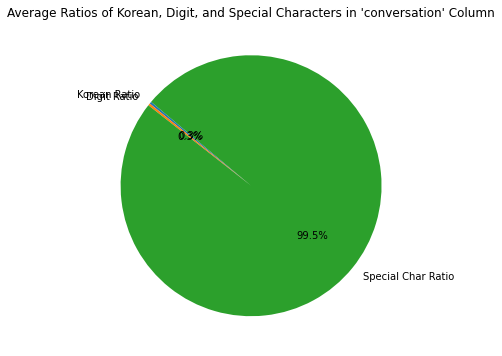

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 각 비율을 저장할 리스트 초기화
korean_ratio_list = []
digit_ratio_list = []
special_char_ratio_list = []

for text in train['conversation']:
    # 한글 비율 계산
    korean_count = sum(c.isdigit() for c in text)
    korean_ratio = korean_count / len(text)
    korean_ratio_list.append(korean_ratio)

    # 숫자 비율 계산
    digit_count = sum(c.isdigit() for c in text)
    digit_ratio = digit_count / len(text)
    digit_ratio_list.append(digit_ratio)

    # 특수문자 비율 계산
    special_char_count = len(text) - (korean_count + digit_count)
    special_char_ratio = special_char_count / len(text)
    special_char_ratio_list.append(special_char_ratio)

# 결과를 DataFrame으로 변환
ratio_df = pd.DataFrame({
    'Korean Ratio': korean_ratio_list,
    'Digit Ratio': digit_ratio_list,
    'Special Char Ratio': special_char_ratio_list
})

# 비율에 대한 원 그래프 생성
plt.figure(figsize=(10, 6))
plt.pie(ratio_df.mean(), labels=ratio_df.columns, autopct='%1.1f%%', startangle=140)
plt.title("Average Ratios of Korean, Digit, and Special Characters in 'conversation' Column")
plt.show()


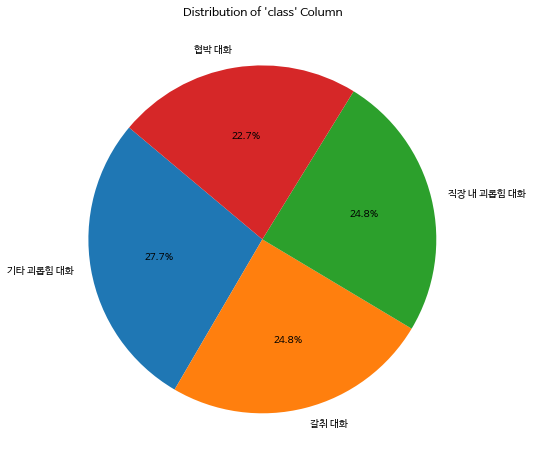

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

# 'class' 컬럼의 값별 데이터 개수 계산
class_counts = train['class'].value_counts()

# 클래스 이름과 데이터 개수를 리스트로 저장
class_names = class_counts.index.tolist()
class_values = class_counts.values.tolist()

# 원 그래프 생성
plt.figure(figsize=(8, 8))
plt.pie(class_values, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of 'class' Column")
plt.show()


In [28]:
train

,idx,class,conversation,A,B
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...,아닙니다. 죄송합니다.\n 정말 잘못했습니다.\n 죄송합니다. 정말 잘못했습니다....
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다.\n네?\n장난전화 걸지 마시죠. \n장난전화는 업무방해죄에 해당됩...,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n지영아 너가 키 160이지?...,그만해. 니들 놀리는거 재미없어.\n너 군대도 안가고 좋겠다.\n난쟁이들도 장가가고...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기\n너 말이야 너. 이리 오라고\n너 옷 좋아보인다?\n아니에요.돈 없어요...,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,아 진짜요? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요!\n음....
...,...,...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...,내 머리가 뭐.\n아니. 무슨 머리만 큰다고 그러는거야\n나한테 왜그러는거야.\n넌...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...,예.? 선생님 진정하시고 우리 말로 해결합시다.\n제발 저희 아들만은 건드리지 말아...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...,왜 그래. 들리겠어.\n하긴 그래서 저번에 부장님도.\n그러게.\n나도 그건 못본거...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...,이게 무슨일입니까?\n관청에 신고다하고 적법하게 장사하는 건데 자릿세라뇨?\n못 드...


# 자연어 종류 찾아보기

In [86]:
train

,idx,class,conversation,A,B
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 죽을 거면 혼자 죽지 우리까지 사...,아닙니다. 죄송합니다.\n 정말 잘못했습니다.\n 죄송합니다. 정말 잘못했습니다....
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다.\n네?\n장난전화 걸지 마시죠. \n장난전화는 업무방해죄에 해당됩...,9시 40분 마트에 폭발물을 설치할거다.\n똑바로 들어 한번만 더 얘기한다.\n9시...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n지영아 너가 키 160이지?...,그만해. 니들 놀리는거 재미없어.\n너 군대도 안가고 좋겠다.\n난쟁이들도 장가가고...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기\n너 말이야 너. 이리 오라고\n너 옷 좋아보인다?\n아니에요.돈 없어요...,예??\n무슨 일.\n얘 돈 좀 있나봐\n뒤져서 나오면 넌 죽는다\n콜. 마지막 기...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,아 진짜요? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요!\n음....
...,...,...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,준하야 넌 대가리가 왜이렇게 크냐?\n밥먹으면 대가리만 크냐 너는?\n주위를 둘러봐...,내 머리가 뭐.\n아니. 무슨 머리만 큰다고 그러는거야\n나한테 왜그러는거야.\n넌...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n말로?...,예.? 선생님 진정하시고 우리 말로 해결합시다.\n제발 저희 아들만은 건드리지 말아...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n들리라고 해. 아니...,왜 그래. 들리겠어.\n하긴 그래서 저번에 부장님도.\n그러게.\n나도 그건 못본거...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,누구맘대로 여기서 장사하래?\n남의 구역에서 장사하려면 자릿세를 내야지.\n그거랑 ...,이게 무슨일입니까?\n관청에 신고다하고 적법하게 장사하는 건데 자릿세라뇨?\n못 드...


In [94]:
train[(train['A'].str.contains('미안')) | train['B'].str.contains('미안')]

,idx,class,conversation,A,B
35,35,기타 괴롭힘 대화,너 내가 쳐다보지 말랬지\n미안 근데 본거 아니야\n지금 쳐다보고 있잖아\n아니야 ...,너 내가 쳐다보지 말랬지\n지금 쳐다보고 있잖아\n본 거 맞네. 왜 거짓말해? 거짓...,미안 근데 본거 아니야\n아니야 일부러 본게 아니야\n.응\n미안해 잘못했어\n반성...
46,46,기타 괴롭힘 대화,야 재형아\n미친 새끼가 누구 보고 재형이래 더럽네\n하.\n하.? 야 새끼야 내가...,야 재형아\n하.\n야 재형이 보고 새끼라고 하지마 새끼란 욕이 불쌍해\n그래 야 ...,미친 새끼가 누구 보고 재형이래 더럽네\n하.? 야 새끼야 내가 더 기분나빠 존제자...
47,47,기타 괴롭힘 대화,야 제 민호봐바 팔 한짝 밖에 없어\n애들아 놀리지마. \n야 뭘 놀린다고 그러냐 ...,야 제 민호봐바 팔 한짝 밖에 없어\n야 뭘 놀린다고 그러냐 놀리는거 아니야\n하....,애들아 놀리지마. \n내가 듣기에는 놀리는거로 밖에 안들려\n갑자기 왜 그래. \n...
65,65,기타 괴롭힘 대화,야 빵좀 사와 \n미안해 나영아 나 오늘은 돈이 없어\n아니 이 미친놈이 그럼 다른...,야 빵좀 사와 \n아니 이 미친놈이 그럼 다른 애들 삥 뜯어서라도 구해와\n이 새끼...,미안해 나영아 나 오늘은 돈이 없어\n아니 내가 어떡해 그렇게 하니\n너 이상해 도...
69,69,협박 대화,너 왜 내말 안듣는데?\n들을게.\n말만 그렇게 하고 니가 하는게 없는데? 너 그럴...,너 왜 내말 안듣는데?\n말만 그렇게 하고 니가 하는게 없는데? 너 그럴때마다 진짜...,들을게.\n그래도 죽이고 싶다니.\n진정해 \n미안해.\n안그럴게
...,...,...,...,...,...
3872,3872,갈취 대화,야 가지고 왔냐?\n미안해. 아버지가 안 주무셔서 못가지고 나왔어.\n새끼야. 그럼...,야 가지고 왔냐?\n새끼야. 그럼 만들어 왔어야지. 내가 만만해보이지?\n씨발. 장...,미안해. 아버지가 안 주무셔서 못가지고 나왔어.\n미안. 그렇게 큰 돈은 못구하겠어...
3892,3892,기타 괴롭힘 대화,기분나쁘게 왜 쳐다봐\n안쳐다봤는데\n재수없게 이게 확\n왜그래\n왜? 니 눈깔이 ...,기분나쁘게 왜 쳐다봐\n재수없게 이게 확\n왜? 니 눈깔이 맘에 안든다고\n그러지마...,안쳐다봤는데\n왜그래\n그러지마\n미안해 안쳐다볼께\n미안.
3940,3940,기타 괴롭힘 대화,애들아 공연 연습하자.\n이번주에 최종 평가 있어. 빨리 하자.\n야 김정미 너는 ...,애들아 공연 연습하자.\n야 김정미 너는 왜 맨날 이 부분에서 틀려?\n너 때문에 ...,이번주에 최종 평가 있어. 빨리 하자.\n어. 미안해 내가 더 연습해야 했는데\n미...
3941,3941,갈취 대화,동생아 내가 정말 급해서 그러는데 백만원만 빌려줄수있니?\n또?? 무슨일인데 그래?...,동생아 내가 정말 급해서 그러는데 백만원만 빌려줄수있니?\n그거까지 해서 다음에 다...,또?? 무슨일인데 그래? 지난번에 빌려간 돈도 아직 안갚았잖아.\n지난번 빌려준돈도...


# 한글 외 존재하는 특수문자 찾아보기 

## Train 데이터

- 한글 외 존재
    - \n
    - ?                   
    - ？ # 이상한 물음표
    - . 
    - ,
    - !                    
    - '　' # 탭으로 추정
    - ' 
    - ” # " 와 다름 
    - 공백 
    - 숫자          
    - 영어 없음    
    - 이모티콘 없음

In [53]:
import pandas as pd
import re

# 
train['c'] = train['conversation'].apply(lambda x : x.replace('\n','').replace('”','').replace('？','').replace("'",'').replace('　','').replace('?','').replace('!','').replace('.','').replace(',','').replace(' ',''))

# 숫자를 포함하는 정규식 패턴
numeric_pattern = re.compile(r'\d+')

def remove_numeric(text):
    return re.sub(numeric_pattern, '', text)

train['c'] = train['c'].apply(remove_numeric)

# 한글이 아닌 문자열을 포함하는 정규식 패턴
non_korean_pattern = re.compile(r'[^\u3131-\u3163\uac00-\ud7a3]+')

non_korean_data = train[train['c'].str.contains(non_korean_pattern)]['c']
non_korean_data

Series([], Name: c, dtype: object)

## Test 

- 한글 외 존재
    - \n
    - '
    - .
    - !
    - ?
    - 공백
    - 숫자
    - 공백
    - 영어 없음

In [54]:
import pandas as pd
import re

# 
test['c'] = test['conversation'].apply(lambda x : 
                                       x.replace('\n','').replace("'",'').replace('.','').replace('!','').replace('?','').replace(' ',''))

# 숫자를 포함하는 정규식 패턴
numeric_pattern = re.compile(r'\d+')

def remove_numeric(text):
    return re.sub(numeric_pattern, '', text)

test['c'] = test['c'].apply(remove_numeric)

# 한글이 아닌 문자열을 포함하는 정규식 패턴
non_korean_pattern = re.compile(r'[^\u3131-\u3163\uac00-\ud7a3]+')

non_korean_data = test[test['c'].str.contains(non_korean_pattern)]['c']
non_korean_data

Series([], Name: c, dtype: object)

# 물음표, 느낌표 숫자는 필요할까?

## 물음표 

- 전체적으로 많이 사용되고 있음으로 제거해도 무방함

In [55]:
question_rows_all = train[train['conversation'].str.contains('\?')]
question_rows_A = train[train['A'].apply(lambda lst: any('?' in s for s in lst))]
question_rows_B = train[train['B'].apply(lambda lst: any('?' in s for s in lst))]

print(len(question_rows_all['conversation']))
print(len(question_rows_A['A']))
print(len(question_rows_B['B']))

3704
3340
2719


## 느낌표

- 

In [56]:
question_rows_all2 = train[train['conversation'].str.contains('\!')]
question_rows_A2 = train[train['A'].apply(lambda lst: any('!' in s for s in lst))]
question_rows_B2 = train[train['B'].apply(lambda lst: any('!' in s for s in lst))]

print(len(question_rows_all2['conversation']))
print(len(question_rows_A2['A']))
print(len(question_rows_B2['B']))

1280
862
737


## 숫자

- 

In [57]:
number_in_conversation_rows = train[train['conversation'].apply(lambda s: any(c.isdigit() for c in s))]
number_in_A_rows = train[train['A'].apply(lambda lst: any(any(c.isdigit() for c in s) for s in lst))]
number_in_B_rows = train[train['B'].apply(lambda lst: any(any(c.isdigit() for c in s) for s in lst))]

print(len(number_in_conversation_rows['conversation']))
print(len(number_in_A_rows['A']))
print(len(number_in_B_rows['B']))

777
621
335


In [58]:
from soynlp.normalizer import *

def preprocess_sentence(sentence):
    # 이모티콘 정규화 및 반복 정규화 함수 호출
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence) # 문장 내 특수문자 제외한 문자들을 공백으로 변환
    sentence = re.sub(r'!+', '!', sentence) # 여러 개의 느낌표를 하나의 느낌표로 변환
    sentence = re.sub(r'\?+', '?', sentence) # 여러 개의 물음표를 하나의 물음표로 변환
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호와 단어 사이에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)# 여러 개의 공백을 하나의 공백으로 변환
    sentence = sentence.strip()# 문장 앞뒤의 공백 제거
    
    return sentence

In [59]:
train['c_p'] = train['conversation'].apply(preprocess_sentence)

In [60]:
for i, text in enumerate(test['conversation'].values):
    print(text)
    print()
    if i > 5 :
        break

아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네

우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.

너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요

아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도 말해야지? .켰습니다. 주인님. 오냐. 앞으로도 잘부탁한다 와이파이. 넵. 이렇게만 해? 알겠지? 응.

그러니까 빨리 말해. 선생님 제발 살려주십시오.  비밀번호 틀릴 때마다 손톱 하나씩 뺀찌로 뽑는다.  선생님 저도 정말 모릅니다.  하나 엄지 손톱 뽑는다.  으악! 잘못했습니다. 그런데 진짜 모릅니다.  둘 이번에는 두 번째 손톱 뽑는다.  으악! 진짜 저는 모릅니다.  셋 중지를 아주 분질러 줄까?  으아아 살려주십시오.  아니다 아주 손가락을 다 잘라놔야겠다.

그 사람 누구냐?  누구말하는거야?  다 알면서 모른척 하지마. 둘다 쏴버리기 전에.  아니 정말 왜이래? 누굴말하는거냐고.  어제 밤에 전

In [65]:
number_in_conversation_rows = number_in_conversation_rows.reset_index(drop=True)
number_in_conversation_rows = tokenizering('monologg/koelectra-small-v3-discriminator', number_in_conversation_rows)
number_in_conversation_rows

,idx,class,conversation,A,B,c,monologg/koelectra-small-v3-discriminator
0,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,"[길동경찰서입니다., 네?, 장난전화 걸지 마시죠. , 장난전화는 업무방해죄에 해당...","[9시 40분 마트에 폭발물을 설치할거다., 똑바로 들어 한번만 더 얘기한다., 9...",길동경찰서입니다시분마트에폭발물을설치할거다네똑바로들어한번만더얘기한다장난전화걸지마시죠시...,"[길, ##동, ##경찰, ##서, ##입니다, ., 9, ##시, 40, ##분,..."
1,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,"[너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어., 지영아 너가 키 160이지...","[그만해. 니들 놀리는거 재미없어., 너 군대도 안가고 좋겠다., 난쟁이들도 장가가...",너되게귀여운거알지나보다작은남자는첨봤어그만해니들놀리는거재미없어지영아너가키이지그럼재는도...,"[너, 되게, 귀여운, ##거, 알지, ?, 나, ##보, ##다, 작, ##은, ..."
2,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....,"[나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로., 응. 남자친구 부모님한테 ...","[가나다 음식점이요.?, 저.팀장님. 저도 월 말 프로젝트로 정신없어서.죄송하지만....",나이틀뒤에가나다음식점예약좀해줘저녁시로가나다음식점이요응남자친구부모님한테인사드리려는데거...,"[나, 이틀, ##뒤, ##에, 가나, ##다, 음식점, 예약, ##좀, 해, ##..."
3,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...,"[35번 손님 아이스커피 두잔나왔습니다, 네 맛있게드세요, 아 분명 오늘 날이 더우...","[아이스커피? , 저기요 아가씨 나는 아아스 시킨적이 없는데?, 내가 그랫어? , ...",번손님아이스커피두잔나왔습니다아이스커피네맛있게드세요저기요아가씨나는아아스시킨적이없는데아...,"[35, ##번, 손님, 아이스, ##커피, 두, ##잔, ##나, ##왔, ##습..."
4,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...,"[자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?, 얼마나 해먹었어? 괜찮아....","[그게., 회사에는 비밀로 해주십시오., 어느정도.생각하시죠?, 그건 너무 많습니다...",자네세금계산서보내준거메일이랑수치가다르던데그게얼마나해먹었어괜찮아다른업체들도다그래회사에...,"[자네, 세금, ##계, ##산, ##서, 보내, ##준, 거, 메일, ##이, #..."
...,...,...,...,...,...,...,...
772,3930,갈취 대화,어머 일로와봐\n엇 기자님 안녕하세요\n그래그래 이 사진들 뭐야 ?\n아 어디서 이...,"[어머 일로와봐, 그래그래 이 사진들 뭐야 ?, 뭐 옛날 친구들이랑 동네애들이 나한...","[엇 기자님 안녕하세요, 아 어디서 이런사진을, 아 혹시 이거 , 어떻게하면 될까요...",어머일로와봐엇기자님안녕하세요그래그래이사진들뭐야아어디서이런사진을뭐옛날친구들이랑동네애들...,"[어머, 일, ##로, ##와, ##봐, 엇, 기자, ##님, 안녕, ##하, ##..."
773,3934,갈취 대화,야. 돈 좀 내놔\n싫어. 내가 돈이 어딨어.\n죽고싶냐? 빨리 내놔.너 엄마한테 ...,"[야. 돈 좀 내놔, 죽고싶냐? 빨리 내놔.너 엄마한테 용돈 30만원 받은거 알고 ...","[싫어. 내가 돈이 어딨어., 그거 이번달 문제집 사려고 받은 돈이야., 안돼.엄마...",야돈좀내놔싫어내가돈이어딨어죽고싶냐빨리내놔너엄마한테용돈만원받은거알고있어그거이번달문제집...,"[야, ., 돈, 좀, 내놔, 싫, ##어, ., 내, ##가, 돈, ##이, 어딨..."
774,3942,갈취 대화,영지야 나 토익 학원 다니느라 돈을 다써서 그런데 5만원만 빌려주라\n응? 안돼. ...,"[영지야 나 토익 학원 다니느라 돈을 다써서 그런데 5만원만 빌려주라, 영지야. 나...","[응? 안돼. 나 돈 없어., 정말 미안. 나도 밥 사먹을 돈이 없어서 그래., 안...",영지야나토익학원다니느라돈을다써서그런데만원만빌려주라응안돼나돈없어영지야나진짜밥사먹을돈도...,"[영지, ##야, 나, 토익, 학원, 다니, ##느, ##라, 돈, ##을, 다, ..."
775,3943,갈취 대화,인테리어 하는데 예상보다 돈이 1200만원 더 들어서 그 돈 주셔야 해요.\n120...,"[인테리어 하는데 예상보다 돈이 1200만원 더 들어서 그 돈 주셔야 해요., 아니...",[1200이요? 마감도 엉성하고 마음에 드는거 하나 없는데 제가 여기에서 돈을 더 ...,인테리어하는데예상보다돈이만원더들어서그돈주셔야해요이요마감도엉성하고마음에드는거하나없는데...,"[인테리어, 하, ##는데, 예상, ##보, ##다, 돈, ##이, 1200, ##..."


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3950 non-null   int64 
 1   class         3950 non-null   object
 2   conversation  3950 non-null   object
 3   A             3950 non-null   object
 4   B             3950 non-null   object
 5   c             3950 non-null   object
 6   c_p           3950 non-null   object
dtypes: int64(1), object(6)
memory usage: 216.1+ KB


In [72]:
train[train.duplicated(subset=['conversation']) ][10:20]

,idx,class,conversation,A,B,c,c_p
1259,1259,기타 괴롭힘 대화,야 이 길동.\n네 선배님!\n오늘은 왠지 더 커진거 같다? 원래도 어마어마 했지만...,"[야 이 길동., 오늘은 왠지 더 커진거 같다? 원래도 어마어마 했지만. 안그러냐?...","[네 선배님!, 그러네! 뽕이야?, 아니 네 키 말이야. 키, 그게 아니라 누가 들...",야이길동네선배님오늘은왠지더커진거같다원래도어마어마했지만안그러냐그러네뽕이야네뭐라고요아니...,야 이 길동 . 네 선배님 ! 오늘은 왠지 더 커진거 같다 ? 원래도 어마어마 했지...
1426,1426,협박 대화,5년전 너가 나한테 상처줬던 말들 다 사과해\n내가 너한테 뭘 어쨌는데?\n가해자는...,"[5년전 너가 나한테 상처줬던 말들 다 사과해, 가해자는 기억 못한다더니. 넌 오늘...","[내가 너한테 뭘 어쨌는데?, 그 총으로 날 쏘겠다는 거야?, 장난감 총으로 날 협...",년전너가나한테상처줬던말들다사과해내가너한테뭘어쨌는데가해자는기억못한다더니넌오늘내손에죽어...,년전 너가 나한테 상처줬던 말들 다 사과해 내가 너한테 뭘 어쨌는데 ? 가해자는 기...
1453,1453,기타 괴롭힘 대화,야 게이\n게이 아니라고\n맞잖아 게이새끼야\n아 아니야\n이새끼 전에 소설 보는거...,"[야 게이, 맞잖아 게이새끼야, 이새끼 전에 소설 보는거 봤어, 존나 같잖네 니가 ...","[게이 아니라고, 아 아니야, 아니라고 그냥 소설이었어, 때리지마, 아.]",야게이게이아니라고맞잖아게이새끼야아아니야이새끼전에소설보는거봤어아니라고그냥소설이었어존나...,야 게이 게이 아니라고 맞잖아 게이새끼야 아 아니야 이새끼 전에 소설 보는거 봤어 ...
1482,1482,기타 괴롭힘 대화,아 멍청한 프린터기 같으니라고\n야 왜그래\n프린터가 제대로 안되잖아\n내가 해볼게...,"[아 멍청한 프린터기 같으니라고, 프린터가 제대로 안되잖아, 오 대박, 맞아, 그정...","[야 왜그래, 내가 해볼게 됐지?, 으이구 기계치, 너 카톡프사도 바꿀줄 모르지?,...",아멍청한프린터기같으니라고야왜그래프린터가제대로안되잖아내가해볼게됐지오대박으이구기계치맞아...,아 멍청한 프린터기 같으니라고 야 왜그래 프린터가 제대로 안되잖아 내가 해볼게 됐지...
1502,1502,기타 괴롭힘 대화,야 너 반지하에서 산다며?\n응.그게 왜?\n헐나같으면 벌레 엄청 나오는 반지하에서...,"[야 너 반지하에서 산다며?, 헐나같으면 벌레 엄청 나오는 반지하에서는 못살겠다.,...","[응.그게 왜?, 벌레 없고 살만해 괜찮아., 무슨 말을 그렇게 해., 그렇구나 좋...",야너반지하에서산다며응그게왜헐나같으면벌레엄청나오는반지하에서는못살겠다벌레없고살만해괜찮아...,야 너 반지하에서 산다며 ? 응 . 그게 왜 ? 헐나같으면 벌레 엄청 나오는 반지하...
1504,1504,기타 괴롭힘 대화,어휴 야 넌 왤케 뚱뚱하냐?\n내가 뚱뚱한게 뭐 어때서\n야 보기만해도 역겨워\n내...,"[어휴 야 넌 왤케 뚱뚱하냐?, 야 보기만해도 역겨워, 어 당연히 됐지, 야 보기만...","[내가 뚱뚱한게 뭐 어때서, 내가 뚱뚱한게 너한테 무슨 피해가 됐니?, 뭔소리를 하...",어휴야넌왤케뚱뚱하냐내가뚱뚱한게뭐어때서야보기만해도역겨워내가뚱뚱한게너한테무슨피해가됐니어...,어휴 야 넌 왤케 뚱뚱하냐 ? 내가 뚱뚱한게 뭐 어때서 야 보기만해도 역겨워 내가 ...
1506,1506,기타 괴롭힘 대화,너가 쓴글 다 구라아님?\n진짠데.\n증명해봐. 어떻게 믿냐?\n인터넷이라 신상털려...,"[너가 쓴글 다 구라아님?, 증명해봐. 어떻게 믿냐?, 인터넷이라고 그렇게 구라치고...","[진짠데., 인터넷이라 신상털려서 안돼., 믿기 싫으면 믿지마., 그만 대화걸었으면...",너가쓴글다구라아님진짠데증명해봐어떻게믿냐인터넷이라신상털려서안돼인터넷이라고그렇게구라치고...,너가 쓴글 다 구라아님 ? 진짠데 . 증명해봐 . 어떻게 믿냐 ? 인터넷이라 신상털...
1537,1537,기타 괴롭힘 대화,어 누구 닮은셧는데 ?\n누구요\n연예인 그 . 그 .\n연예인은 다 너무 이쁘잖아...,"[어 누구 닮은셧는데 ?, 연예인 그 . 그 ., 에이 개그우먼은 아니잖아요, 그럼...","[누구요, 연예인은 다 너무 이쁘잖아요, 네 ? 개그우먼요 ?, 아 제가 오버했네뇨...",어누구닮은셧는데누구요연예인그그연예인은다너무이쁘잖아요에이개그우먼은아니잖아요네개그우먼요...,어 누구 닮은셧는데 ? 누구요 연예인 그 . 그 . 연예인은 다 너무 이쁘잖아요 에...
1557,1557,기타 괴롭힘 대화,아 냄새.\n 무슨 냄새?\n 어디에서 썩는 냄새가.\n 그만해.\n 너보니까 음식...,"[아 냄새., 어디에서 썩는 냄새가., 너보니까 음식 쓰레기 냄새난다., 야 ...","[ 무슨 냄새?, 그만해., 가 비켜., 가라고., 제발 좀 그만 놀려. 나...",아냄새무슨냄새어디에서썩는냄새가그만해너보니까음식쓰레기냄새난다가비켜야음쓰가라고너썩었어얼...,아 냄새 . 무슨 냄새 ? 어디에서 썩는 냄새가 . 그만해 . 너보니까 음식 쓰레기...
1567,1567,기타 괴롭힘 대화,저기요. 쿠팡잇츠에서 시킨 사람인데요. 빙수 맛이 다른데요?\n네? 그럴리가 없는데...,"[저기요. 쿠팡잇츠에서 시킨 사람인데요. 빙수 맛이 다른데요?, 203번이요, 네....","[네? 그럴리가 없는데. 혹시 주문번호가 어떻게 되나요.?, 아. 사인머스켓 팥빙수...",저기요쿠팡잇츠에서시킨사람인데요빙수맛이다른데요네그럴리가없는데혹시주문번호가어떻게되나요번...,저기요 . 쿠팡잇츠에서 시킨 사람인데요 . 빙수 맛이 다른데요 ? 네 ? 그럴리가 ...


In [41]:
def tokenizering(model_name, df, max_len=512):
    tokenizer = ElectraTokenizer.from_pretrained(model_name)
    tokenized_text = [ tokenizer.tokenize(text) for text in list(df['conversation'].values) ] 
    col_name = df.columns
    df = pd.concat([df,pd.DataFrame([tokenized_text]).transpose()],axis=1, ignore_index= True)
    df.columns = list(col_name) + [model_name]
    return df

test = tokenizering('monologg/koelectra-small-v3-discriminator', test)


In [42]:
test

,file_name,conversation,c,monologg/koelectra-small-v3-discriminator
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,아가씨담배한갑주소네원입니다어네지갑어디갔지에이버스에서잃어버렸나보네그럼취소할까요아가씨내...,"[아가씨, 담배, ##한, ##갑, ##주, ##소, 네, 4500, ##원, ##..."
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,우리팀에서다른팀으로갈사람없나그럼영지씨가가는건어때네제가요그렇지달만파견잘갔다오면승진이야...,"[우리, ##팀, ##에, ##서, 다른, ##팀, ##으로, 갈, 사람, 없, #..."
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,너오늘그게뭐야네제가뭘잘못했나요제대로좀하지네똑바로좀하지행실이맘에안들어네실천할께요옆에동...,"[너, 오늘, 그게, 뭐, ##야, 네, 제, ##가, 뭘, 잘못, ##했, ##나..."
3,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,아무튼앞으로니가내와이파이야응와이파이온켰어반말주인님이라고도말해야지켰습니다주인님오냐앞으...,"[아무튼, 앞, ##으로, 니, ##가, 내, 와이파이, ##야, ., ., 응, ..."
4,t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,그러니까빨리말해선생님제발살려주십시오비밀번호틀릴때마다손톱하나씩뺀찌로뽑는다선생님저도정말...,"[그러니까, 빨리, 말, ##해, ., 선생, ##님, 제발, 살려, ##주, ##..."
...,...,...,...,...
395,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,미나씨휴가결제올리기전에저랑상의하라고말한거기억해요네합니다보고서를보니저에게상의안한내용이...,"[미나, ##씨, 휴가, 결제, 올리, ##기, 전, ##에, 저, ##랑, 상의,..."
396,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,교수님제논문에제이름이없나요아무슨논문말이야지난번냈던논문이요그거제가저자로쓴건데그랬던가흠...,"[교수, ##님, 제, 논문, ##에, 제, 이름, ##이, 없, ##나, ##요,..."
397,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,야너네저요그래너왜요돈좀줘봐돈없어요돈이왜없어지갑은폼이니진짜없어요줘봐내가확인할거니까제발...,"[야, 너, 네, 저, ##요, ?, 그래, 너, 왜, ##요, 돈, ##좀, 줘,..."
398,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,야너빨리안뛰어와너이환자제대로봤어안봤어어제저녁부터계속보다가지금과장님께서잠시부르셔서다녀...,"[야, 너, 빨리, 안, 뛰어, ##와, ?, 너, 이, 환자, 제대로, 봤, ##..."


## 대화 왕복 분포

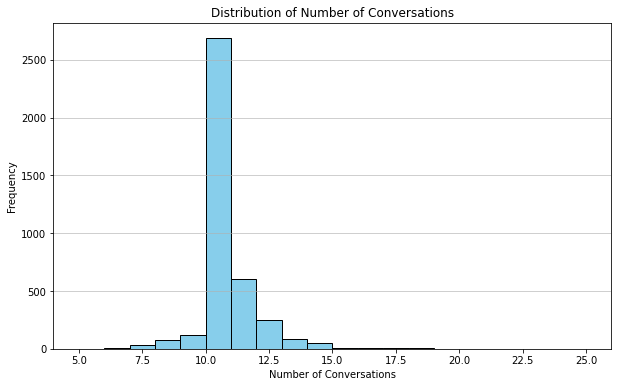

In [17]:
import matplotlib.pyplot as plt

# \n을 기준으로 대화 분리하고 대화 수 계산
train['conversation_count'] = train['conversation'].apply(lambda x: len(x.split('\n')))

# 대화 수 시각화
plt.figure(figsize=(10, 6))
plt.hist(train['conversation_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Conversations')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Conversations')
plt.grid(axis='y', alpha=0.75)
plt.show()


## 대화 길이 분포

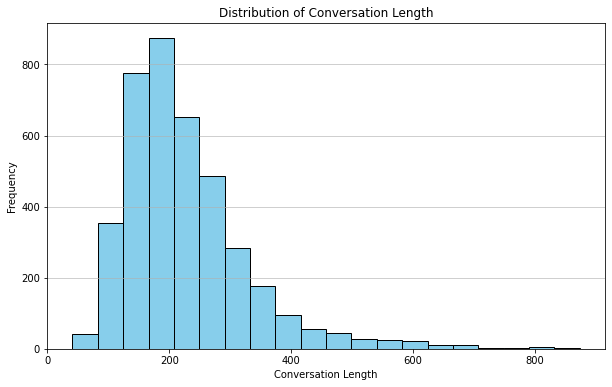

In [18]:
import matplotlib.pyplot as plt

# 대화의 길이 계산
train['conversation_length'] = train['conversation'].apply(lambda x: len(x))

# 대화 길이 시각화
plt.figure(figsize=(10, 6))
plt.hist(train['conversation_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Conversation Length')
plt.ylabel('Frequency')
plt.title('Distribution of Conversation Length')
plt.grid(axis='y', alpha=0.75)
plt.show()


## 토큰 수 분포


## 토큰별 길이 평균 분포


## 토크나이저 통계

- monologg/koelectra-small-v3-discriminator


- 디코드 : decoded_text = tokenizer.decode(tokens['input_ids'][0])
- tokenizer.get_vocab
- 토크나이저 : tokenizer.tokenize(text)
- 인코드 : tokenizer.encode(text)

In [200]:
def tokenizering(model_name,df, max_len=512):
    tokenizer = ElectraTokenizer.from_pretrained(model_name)
    tokenized_text = [ tokenizer.tokenize(text) for text in list(df['conversation'].values) ] 
    col_name = df.columns
    df = pd.concat([df,pd.DataFrame([tokenized_text]).transpose()],axis=1, ignore_index= True)
    df.columns = list(col_name) + [model_name]
    return train

train = tokenizering('monologg/koelectra-small-v3-discriminator', train)
train.head()

,idx,class,conversation,conversation_count,conversation_length,monologg/koelectra-small-v3-discriminator
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,10,242,"[지금, 너, 스스로, ##를, 죽여, ##달라, ##고, 애원, ##하, ##는,..."
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,10,188,"[길, ##동, ##경찰, ##서, ##입니다, ., 9, ##시, 40, ##분,..."
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,10,218,"[너, 되게, 귀여운, ##거, 알지, ?, 나, ##보, ##다, 작, ##은, ..."
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,11,115,"[어이, 거기, 예, ?, ?, 너, 말, ##이, ##야, 너, ., 이리, 오라..."
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,12,460,"[저기, ##요, 혹시, 날, ##이, 너무, 뜨겁, ##잖아요, ?, 저희, 회사..."


In [258]:
train 
# ko-bert : 석영님 민식님 토크나이저 간 차이점 조사? -
# 토크나이저가 못하는 전처리를 미리 수행...
# 

,idx,class,conversation,conversation_count,conversation_length,monologg/koelectra-small-v3-discriminator,mecab_nouns
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,10,242,"[지금, 너, 스스로, ##를, 죽여, ##달라, ##고, 애원, ##하, ##는,...","[너, 스스로, 애원, 것, 거, 우리, 사건, 너, 선택, 너, 가족, 너, 선택..."
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,10,188,"[길, ##동, ##경찰, ##서, ##입니다, ., 9, ##시, 40, ##분,...","[길동, 경찰서, 시, 분, 마트, 폭발물, 설치, 거, 번, 얘기, 장난, 전화,..."
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,10,218,"[너, 되게, 귀여운, ##거, 알지, ?, 나, ##보, ##다, 작, ##은, ...","[너, 거, 나, 남자, 니, 거, 지영, 너, 키, 재, 도, 거, 너, 군대, ..."
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,11,115,"[어이, 거기, 예, ?, ?, 너, 말, ##이, ##야, 너, ., 이리, 오라...","[거기, 너, 말, 너, 일, 너, 옷, 돈, 돈, 넌, 피시방, 콜, 콜, 마지막..."
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,12,460,"[저기, ##요, 혹시, 날, ##이, 너무, 뜨겁, ##잖아요, ?, 저희, 회사...","[저기, 날, 저희, 회사, 선크림, 번, 손등, 선크림, 필요, 중, 번, 여기,..."
...,...,...,...,...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,11,233,"[준하, ##야, 넌, 대가, ##리, ##가, 왜, ##이, ##렇, ##게, 크...","[넌, 대가리, 내, 머리, 밥, 대가리, 너, 머리, 거, 주위, 내, 너, 대가..."
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,10,223,"[내, ##가, 지금, 너, 아들, 김, ##길, ##준, 데리, ##고, 있, #...","[내, 너, 아들, 김길준, 계좌, 억만, 선생, 진정, 우리, 말, 해결, 말, ..."
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,11,301,"[나, ##는, 씨, 같, ##은, 사람, 보, ##면, 참, 신기, ##하, ##...","[나, 씨, 사람, 일, 눈치, 본인, 저번, 부장, 부장, 분, 말, 회사, 생활..."
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,10,225,"[누구, ##맘, ##대로, 여기, ##서, 장사, ##하, ##래, ?, 이게, ...","[누구, 여기, 장사, 이게, 일, 남, 구역, 장사, 자릿세, 관청, 장사, 건데..."


## 형태소 통계


In [213]:
def get_mecab_nouns(df):
    mecab = Mecab()
    nouns = [mecab.nouns(text) for text in df['conversation']]
    col_name = df.columns
    df = pd.concat([df,pd.DataFrame([nouns]).transpose()],axis=1, ignore_index= True)
    df.columns = list(col_name) + ['mecab_nouns']
    return df

train = get_mecab_nouns(train)
train.head()

,idx,class,conversation,conversation_count,conversation_length,monologg/koelectra-small-v3-discriminator,mecab_nouns
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,10,242,"[지금, 너, 스스로, ##를, 죽여, ##달라, ##고, 애원, ##하, ##는,...","[너, 스스로, 애원, 것, 거, 우리, 사건, 너, 선택, 너, 가족, 너, 선택..."
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,10,188,"[길, ##동, ##경찰, ##서, ##입니다, ., 9, ##시, 40, ##분,...","[길동, 경찰서, 시, 분, 마트, 폭발물, 설치, 거, 번, 얘기, 장난, 전화,..."
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,10,218,"[너, 되게, 귀여운, ##거, 알지, ?, 나, ##보, ##다, 작, ##은, ...","[너, 거, 나, 남자, 니, 거, 지영, 너, 키, 재, 도, 거, 너, 군대, ..."
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,11,115,"[어이, 거기, 예, ?, ?, 너, 말, ##이, ##야, 너, ., 이리, 오라...","[거기, 너, 말, 너, 일, 너, 옷, 돈, 돈, 넌, 피시방, 콜, 콜, 마지막..."
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,12,460,"[저기, ##요, 혹시, 날, ##이, 너무, 뜨겁, ##잖아요, ?, 저희, 회사...","[저기, 날, 저희, 회사, 선크림, 번, 손등, 선크림, 필요, 중, 번, 여기,..."


In [214]:
train['class'].value_counts()

기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: class, dtype: int64

In [224]:
from collections import Counter
from konlpy.tag import Mecab

# 예시 데이터 (클래스 별로 분류된 텍스트)
기타_texts = list(train[train['class'] == '기타 괴롭힘 대화']['conversation'].values)
갈취_texts = list(train[train['class'] == '갈취 대화']['conversation'].values)
직장_texts = list(train[train['class'] == '직장 내 괴롭힘 대화']['conversation'].values)
협박_texts = list(train[train['class'] == '협박 대화']['conversation'].values)

# Mecab 인스턴스 생성
mecab = Mecab()

stop_words_len_1 = '너거나내말게뭐니만씨'
stop_words_len_1 = [i for i in stop_words_len_1]

# 클래스 별로 토큰화하여 토큰 빈도 계산
def calculate_most_common_words(texts, top_n=5):
    tokens = []
    for text in texts:
        parsed = mecab.nouns(text)
        parsed = [i for i in parsed if i not in stop_words_len_1]
        tokens.extend(parsed)
    token_counts = Counter(tokens)
    most_common_words = token_counts.most_common(top_n)  # 가장 빈도가 높은 단어 n개 반환
    return most_common_words

# 각 클래스의 가장 많이 나오는 단어 계산 (상위 3개 단어)
most_common_class1 = calculate_most_common_words(기타_texts, top_n=10)
most_common_class2 = calculate_most_common_words(갈취_texts, top_n=10)
most_common_class3 = calculate_most_common_words(직장_texts, top_n=10)
most_common_class4 = calculate_most_common_words(협박_texts, top_n=10)

print("기타 단어:", most_common_class1)
print("갈취 단어:", most_common_class2)
print("직장 단어:", most_common_class3)
print("협박 단어:", most_common_class4)

기타 단어: [('우리', 341), ('애', 295), ('것', 278), ('사람', 252), ('친구', 226), ('여기', 223), ('미안', 208), ('제', 203), ('일', 188), ('이거', 187)]
갈취 단어: [('돈', 1538), ('원', 621), ('이거', 422), ('제', 253), ('일', 248), ('여기', 227), ('친구', 221), ('우리', 220), ('이번', 208), ('수', 205)]
직장 단어: [('일', 1049), ('제', 508), ('회사', 455), ('것', 442), ('대리', 437), ('김', 318), ('부장', 312), ('사람', 288), ('저', 283), ('우리', 243)]
협박 단어: [('수', 349), ('우리', 337), ('사람', 309), ('일', 290), ('제', 247), ('것', 243), ('번', 234), ('돈', 234), ('집', 189), ('하나', 180)]


### 협박 에서 가장 많이 나오는 명사 찾기 

In [253]:
def most_nouns(df, target, stopwords, top_n=10):
    def calculate_most_common_words(texts, top_n=5):
        tokens = []
        for text in texts:
            parsed = mecab.nouns(text)
            parsed = [i for i in parsed if i not in stopwords[target][1]]
            parsed = [i for i in parsed if i not in stopwords[target][2]]
            tokens.extend(parsed)
        token_counts = Counter(tokens)
        most_common_words = token_counts.most_common(top_n)  # 가장 빈도가 높은 단어 n개 반환
        return most_common_words
    
    mecab = Mecab()
    texts = list(train[train['class'].str.find(target) == -1]['conversation'].values)
    
    most_nouns = calculate_most_common_words(texts, top_n=top_n)
    return most_nouns

In [257]:
stopwords = {
    '협박' : {
        1 : '너거내나말니수게제것번뭐집전딸넌난때애줄일돈원저씨만김뭘건',
        2 : ['우리','이거','여기'],
        3 : '',
    },
}
print(most_nouns(train,'협박',stopwords,50))

[('사람', 692), ('친구', 552), ('회사', 506), ('이번', 489), ('생각', 455), ('대리', 454), ('어디', 434), ('시간', 413), ('미안', 402), ('그건', 400), ('엄마', 398), ('그게', 385), ('말씀', 335), ('새끼', 333), ('그거', 328), ('데', 320), ('부장', 316), ('하나', 313), ('자네', 287), ('이게', 273), ('앞', 262), ('소리', 246), ('저희', 239), ('부탁', 225), ('과장', 225), ('다음', 223), ('저번', 220), ('옷', 218), ('이건', 216), ('부모', 213), ('손', 212), ('건데', 209), ('누가', 209), ('누구', 202), ('선생', 201), ('얼굴', 199), ('남자', 198), ('고객', 198), ('사장', 195), ('업무', 194), ('학교', 190), ('신고', 186), ('기분', 186), ('오늘', 184), ('필요', 182), ('얘기', 179), ('휴가', 179), ('거기', 174), ('내일', 173), ('달', 173)]


In [232]:
협박_texts = list(train[train['class'] == '협박 대화']['conversation'].values)

# Mecab 인스턴스 생성
mecab = Mecab()

stop_words_len_1 = '너거내나말니수게제것번뭐집전딸넌난때애줄일돈'
stop_words_len_1 = [i for i in stop_words_len_1]

# 클래스 별로 토큰화하여 토큰 빈도 계산
def calculate_most_common_words(texts, top_n=5):
    tokens = []
    for text in texts:
        parsed = mecab.nouns(text)
        parsed = [i for i in parsed if i not in stop_words_len_1]
        tokens.extend(parsed)
    token_counts = Counter(tokens)
    most_common_words = token_counts.most_common(top_n)  # 가장 빈도가 높은 단어 n개 반환
    return most_common_words

most_common_class4 = calculate_most_common_words(협박_texts, top_n=20)

print("협박 단어:", most_common_class4)

협박 단어: [('우리', 337), ('사람', 309), ('하나', 180), ('어디', 178), ('여기', 177), ('생각', 177), ('당신', 175), ('가족', 171), ('미안', 170), ('칼', 169), ('소리', 157), ('신고', 152), ('시간', 151), ('새끼', 139), ('정신', 131), ('저', 124), ('이거', 122), ('경찰', 120), ('그게', 116), ('날', 112)]


### 직장 에서 가장 많이 나오는 명사 찾기 

In [231]:
직장_texts = list(train[train['class'] == '직장 내 괴롭힘 대화']['conversation'].values)

# Mecab 인스턴스 생성
mecab = Mecab()

stop_words_len_1 = '거내말너제씨나것김게저일뭐수때번'
stop_words_len_1 = [i for i in stop_words_len_1]

# 클래스 별로 토큰화하여 토큰 빈도 계산
def calculate_most_common_words(texts, top_n=5):
    tokens = []
    for text in texts:
        parsed = mecab.nouns(text)
        parsed = [i for i in parsed if i not in stop_words_len_1]
        tokens.extend(parsed)
    token_counts = Counter(tokens)
    most_common_words = token_counts.most_common(top_n)  # 가장 빈도가 높은 단어 n개 반환
    return most_common_words

most_common_class3 = calculate_most_common_words(직장_texts, top_n=20)

print("직장 단어:", most_common_class3)

직장 단어: [('회사', 455), ('대리', 437), ('부장', 312), ('사람', 288), ('우리', 243), ('자네', 233), ('과장', 223), ('말씀', 219), ('시간', 219), ('이번', 213), ('생각', 207), ('업무', 189), ('이거', 177), ('휴가', 174), ('그게', 155), ('그건', 149), ('커피', 138), ('팀장', 136), ('어디', 132), ('하나', 131)]


## N-gram 통계


## 개체명 분석 및 통계

## 워드 클라우드

In [259]:
from transformers import BertTokenizer

# 불용어 리스트 작성
custom_stopwords = ["불용어1", "불용어2", "불용어3"]

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 불용어를 제외하고 텍스트를 토큰화
text = "이것은 한국어 불용어를 처리하는 예시 문장입니다."
tokens = tokenizer.tokenize(text)
filtered_tokens = [token for token in tokens if token not in custom_stopwords]

print("원본 토큰:", tokens)
print("필터링된 토큰:", filtered_tokens)

원본 토큰: ['이것은', '한국', '##어', '불', '##용', '##어를', '처', '##리', '##하는', '예', '##시', '문', '##장', '##입', '##니다', '.']
필터링된 토큰: ['이것은', '한국', '##어', '불', '##용', '##어를', '처', '##리', '##하는', '예', '##시', '문', '##장', '##입', '##니다', '.']
